# 1. Imports

In [1]:
from concurrent.futures import (
    ThreadPoolExecutor,
    as_completed,
)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os

# 2. Constants

In [2]:
CALCULATE = False
IMAGE_WIDTH = IMAGE_HEIGHT = 512

In [3]:
BASE_DIR = os.path.abspath("")
DATASET = "Agriculture-Vision-2021"
OUTPUT_FOLDER_PATH = os.path.join(BASE_DIR, "output")

BASE_DIR, OUTPUT_FOLDER_PATH

('/mnt/d/AgriNet-Research/agrinet/datasets/Agriculture-Vision-2021',
 '/mnt/d/AgriNet-Research/agrinet/datasets/Agriculture-Vision-2021/output')

In [4]:
dataset_name = "_mini_dataset"
dataset_path = os.path.join(BASE_DIR, dataset_name)
dataset_train_path = os.path.join(dataset_path, "train")
dataset_val_path = os.path.join(dataset_path, "val")
dataset_test_path = os.path.join(dataset_path, "test")
dataset_name, dataset_train_path

('_mini_dataset',
 '/mnt/d/AgriNet-Research/agrinet/datasets/Agriculture-Vision-2021/_mini_dataset/train')

In [5]:
LABELS = {
    0: "drydown",
    1: "nutrient_deficiency",
    2: "weed_cluster",
    3: "water",
    4: "endrow",
    5: "double_plant",
    6: "waterway",
    7: "storm_damage",
    8: "planter_skip",
}

# 3. Verify White Pixel Presence in Label Masks

## Utils:

In [6]:
def check_pixels(image_array: np.ndarray, check_for_pixels: int, mode: str = "any") -> bool:
    """mode: any | all"""
    if mode == "any": return np.any(image_array == check_for_pixels)
    return np.all(image_array == check_for_pixels)

def is_blank_mask(filepath: str, check_for_pixels: int = 0) -> bool:
    try:
        img = Image.open(filepath).convert("L")
        return check_pixels(
            image_array=np.array(img),
            check_for_pixels=check_for_pixels, # black
            mode="all",
        )
    except FileNotFoundError:
        # Return False if the file doesnt exist
        return False

def is_label_mask(filepath: str, *, check_for_pixels: int = 255) -> bool:
    try:
        img = Image.open(filepath).convert("L")
        return check_pixels(
            image_array=np.array(img),
            check_for_pixels=check_for_pixels,
            mode="any",
        )
    except FileNotFoundError:
        # Return False if the file doesnt exist
        return False


def process_label_mask(
    filename: str,
    labels_path: str,
    *,
    ext: str = ".png"
) -> list[int]:
    return [
        1 if is_label_mask(os.path.join(labels_path, label_name, f"{filename}{ext}")) else 0
        for label_name in LABELS.values()
    ]


def process_label_masks_concurrent(
    target_images_paths: list[str],
    labels_path: str,
    *,
    ext: str = ".png",
    max_workers: int = None
) -> pd.DataFrame:
    max_workers = max_workers or cpu_get_max_workers()
    data = []
    columns = ["ID"] + list(LABELS.values())

    def process_single(filepath: str):
        filename, _ = os.path.splitext(os.path.basename(filepath))
        label_results = process_label_mask(
            filename=filename,
            labels_path=labels_path,
            ext=ext
        )
        return [filename] + label_results

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single, fp): fp for fp in target_images_paths}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing masks", unit="file"):
            data.append(future.result())

    return pd.DataFrame(data, columns=columns)


def cpu_get_max_workers() -> int:
    return os.cpu_count() or 1


def get_filepaths(path: str, *, exts: list[str] = []) -> list[str]:
    return [
        os.path.join(path, filename)
        for filename in os.listdir(path)
        if not exts or os.path.splitext(filename)[1] in exts
    ]

In [7]:
def _test():
    path = os.path.join(dataset_train_path, "labels", "endrow")
    mask1 = os.path.join(path, "2I4YH4WR2_1724-5674-2236-6186.png")
    mask2 = os.path.join(path, "1BFUWHD9T_2585-1539-3097-2051.png")
    assert is_label_mask(mask1) == True
    assert is_label_mask(mask2) == False
    %timeit is_label_mask(mask1)


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

7.42 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
def _test():
    limit = 10
    exts = [".jpg",]
    path = os.path.join(dataset_train_path, "images", "rgb")
    target_images_paths = get_filepaths(path, exts = exts)[:limit]
    labels_path = os.path.join(dataset_train_path, "labels")
    
    df = process_label_masks_concurrent(
        target_images_paths = target_images_paths,
        labels_path = labels_path,
    )
    print(df.head())


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

Processing masks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 97.55file/s]

                              ID  drydown  nutrient_deficiency  weed_cluster  \
0   11TAQJ6ET_1288-961-1800-1473        0                    0             0   
1   11IE4DKTR_6121-684-6633-1196        0                    0             0   
2  11TAQJ6ET_1422-8427-1934-8939        0                    0             0   
3  11TAQJ6ET_1567-8177-2079-8689        0                    0             0   
4  11TAQJ6ET_1124-8510-1636-9022        0                    0             0   

   water  endrow  double_plant  waterway  storm_damage  planter_skip  
0      0       0             1         0             0             0  
1      0       0             1         0             0             0  
2      0       0             1         0             0             0  
3      0       0             1         0             0             0  
4      0       0             1         0             0             0  


## Verify:

In [9]:
def verify():
    path = os.path.join(dataset_train_path, "images", "rgb")
    target_images_paths = get_filepaths(path)
    labels_path = os.path.join(dataset_train_path, "labels")

    df = process_label_masks_concurrent(
        target_images_paths = target_images_paths,
        labels_path = labels_path,
    )

    
    df.to_csv(filename, index=False)

In [10]:
dn = dataset_name.replace("/","").lower()
filename = f"{dn}_processed_masks.csv"

if CALCULATE: verify()
df = pd.read_csv(filename)

# 4. EDA

## Check df:

In [11]:
label_columns = df.columns[1:]  # Exclude ID
label_columns

Index(['drydown', 'nutrient_deficiency', 'weed_cluster', 'water', 'endrow',
       'double_plant', 'waterway', 'storm_damage', 'planter_skip'],
      dtype='object')

In [12]:
df.head()

,ID,drydown,nutrient_deficiency,weed_cluster,water,endrow,double_plant,waterway,storm_damage,planter_skip
0,11IE4DKTR_6121-684-6633-1196,0,0,0,0,0,1,0,0,0
1,11TAQJ6ET_1124-8510-1636-9022,0,0,0,0,0,1,0,0,0
2,11TAQJ6ET_1148-8089-1660-8601,0,0,0,0,0,1,0,0,0
3,11TAQJ6ET_1288-961-1800-1473,0,0,0,0,0,1,0,0,0
4,11TAQJ6ET_1995-8426-2507-8938,0,0,0,0,0,1,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   3517 non-null   object
 1   drydown              3517 non-null   int64 
 2   nutrient_deficiency  3517 non-null   int64 
 3   weed_cluster         3517 non-null   int64 
 4   water                3517 non-null   int64 
 5   endrow               3517 non-null   int64 
 6   double_plant         3517 non-null   int64 
 7   waterway             3517 non-null   int64 
 8   storm_damage         3517 non-null   int64 
 9   planter_skip         3517 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 274.9+ KB


## Show image by ID:

In [14]:
def find_by_path(base_name:str, search_path:str) -> list:
    matching_files = []
    base_name = base_name.strip()
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if os.path.splitext(file)[0] == base_name:
                matching_files.append(os.path.join(root, file))
    return matching_files


def show_image_by_id(
    image_id: str,
    search_path: str,
    *,
    max_columns:int = 3,
    exclude_blank:bool = True,
) -> None:
    matches = find_by_path(base_name=image_id, search_path=search_path)
    if exclude_blank: matches = [path for path in matches if not is_blank_mask(path)]
    if not(matches): 
        return print(f"No matches found for image: {image_id}")
    
    # Calculate grid size
    n_images = len(matches)
    n_cols = min(max_columns, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_images > 1 else [axes]  # Handle single image case
    
    for ax, img_path in zip(axes, matches):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        p = os.path.basename(os.path.dirname(img_path))
        f = os.path.basename(img_path)
        ax.set_title(f"{p}/{f}")
    
    # Hide any extra axes if the grid is larger than the number of images
    for ax in axes[len(matches):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

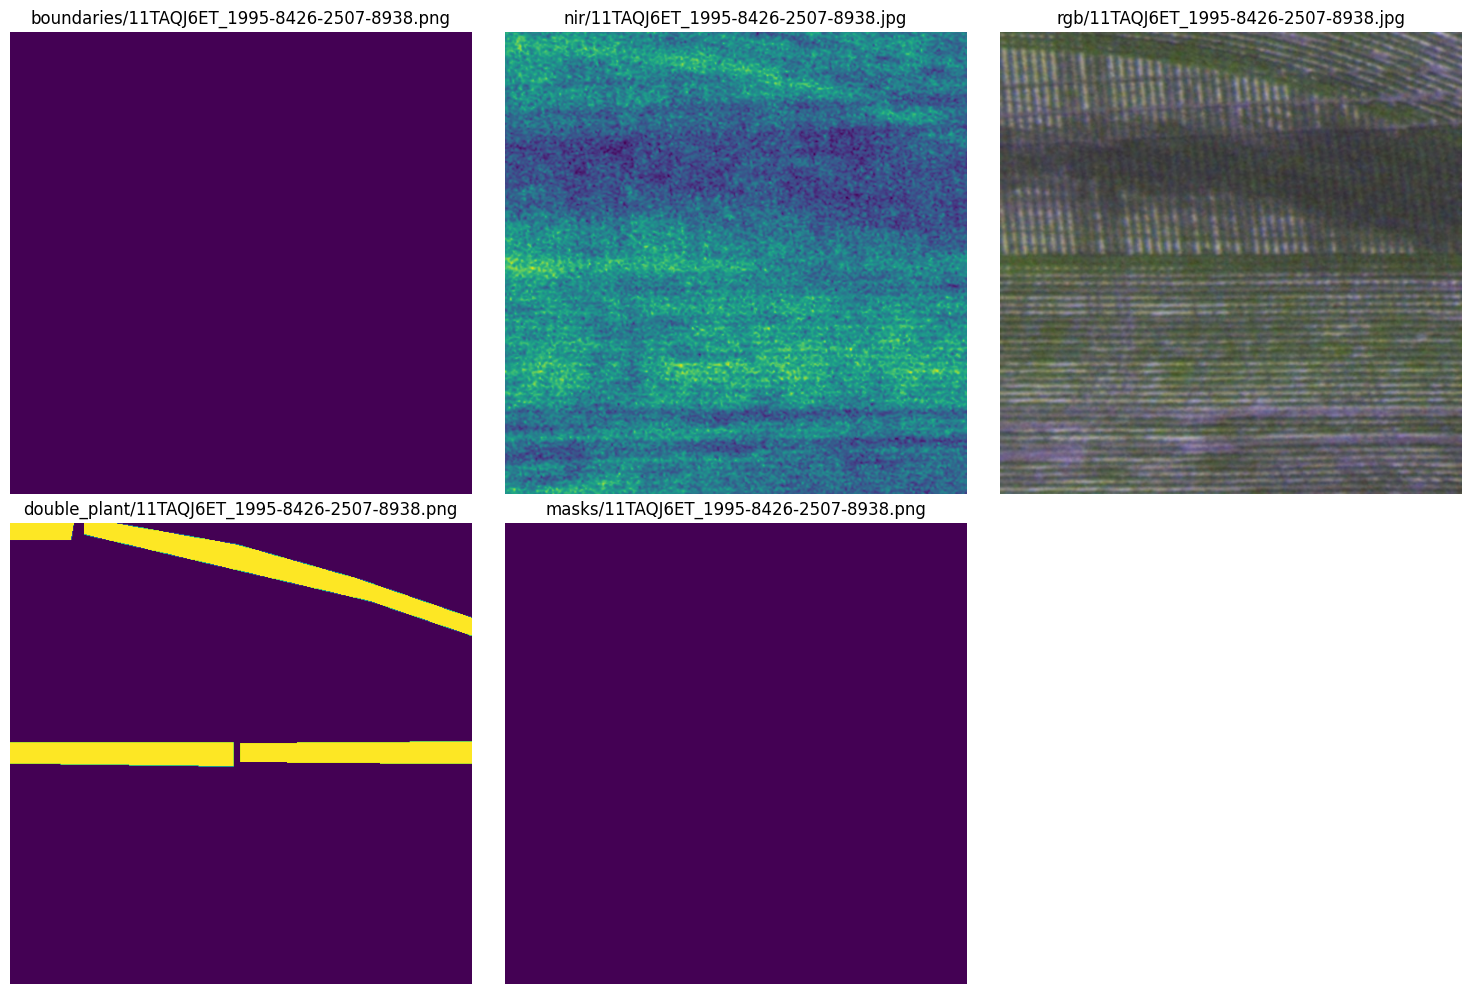

In [15]:
def _test():
    image_id = "11TAQJ6ET_1995-8426-2507-8938"
    show_image_by_id(
        image_id=image_id, 
        search_path=dataset_train_path,
    )


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

## Label Counts:

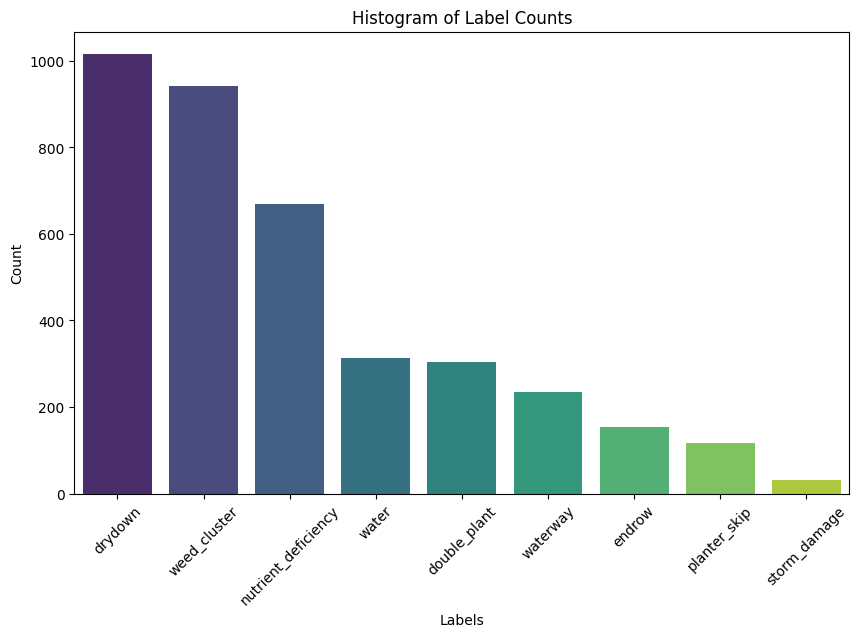

In [16]:
label_counts = df[label_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    dodge=False,
    palette="viridis",
    legend=False,
)
plt.title("Histogram of Label Counts")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Number of Classes on Image:

In [17]:
df["num_classes"] = df[label_columns].sum(axis=1)

num_classes_distribution = df["num_classes"].value_counts().sort_index().to_dict()
print(num_classes_distribution)

{1: 3296, 2: 175, 3: 46}


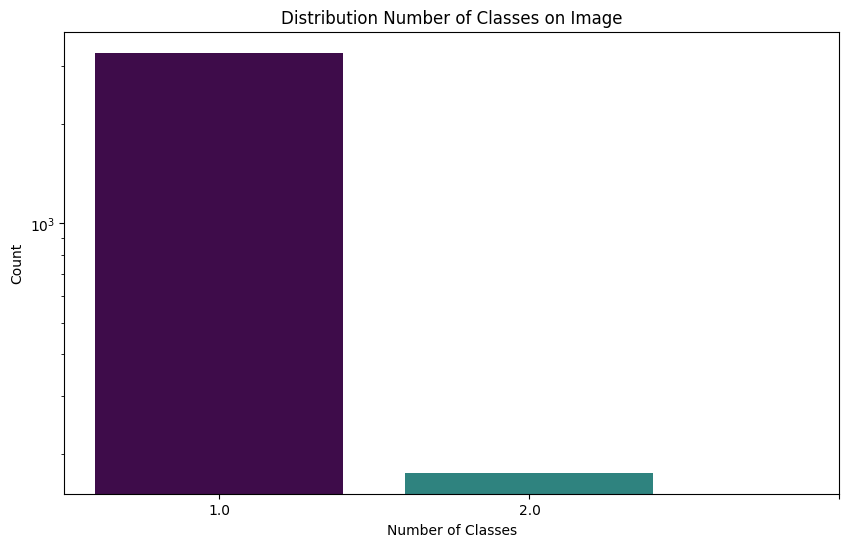

In [18]:
max_classes = df["num_classes"].max()
filtered_df = df[df["num_classes"] < max_classes]

plt.figure(figsize=(10, 6))
sns.countplot(
    data=filtered_df,
    x="num_classes",
    hue=df["num_classes"],
    palette="viridis",
    legend=False,
)
plt.title("Distribution Number of Classes on Image")
plt.xlabel("Number of Classes")
plt.ylabel("Count")
plt.yscale("log")
plt.xticks(range(max_classes))
plt.show()

## Max Number of Classes on Image:

In [19]:
df.sort_values(by="num_classes", ascending=False).head(20)

,ID,drydown,nutrient_deficiency,weed_cluster,water,endrow,double_plant,waterway,storm_damage,planter_skip,num_classes
2323,2A2TMWHRA_8536-13568-9048-14080,0,0,1,0,1,1,0,0,0,3
2966,2I4YH4WR2_7141-352-7653-864,0,1,0,0,1,1,0,0,0,3
2910,2I4YH4WR2_4029-5565-4541-6077,0,1,0,0,1,1,0,0,0,3
2210,2A2TMWHRA_4262-675-4774-1187,0,0,1,0,1,1,0,0,0,3
2211,2A2TMWHRA_4454-13132-4966-13644,0,0,1,0,1,1,0,0,0,3
2213,2A2TMWHRA_4454-13644-4966-14156,0,0,1,0,1,1,0,0,0,3
2326,2A2TMWHRA_8550-13132-9062-13644,0,0,1,0,1,1,0,0,0,3
1823,28VEAXN4T_1396-1227-1908-1739,0,0,1,0,0,1,0,0,1,3
2971,2I4YH4WR2_7395-448-7907-960,0,1,0,0,1,1,0,0,0,3
2892,2I4YH4WR2_2181-5526-2693-6038,0,0,0,0,1,1,0,0,1,3


In [20]:
show_image_by_id(
    image_id="LWJ3IKMP1_9251-3137-9763-3649",
    search_path=dataset_train_path,
)

No matches found for image: LWJ3IKMP1_9251-3137-9763-3649


## Correlation:

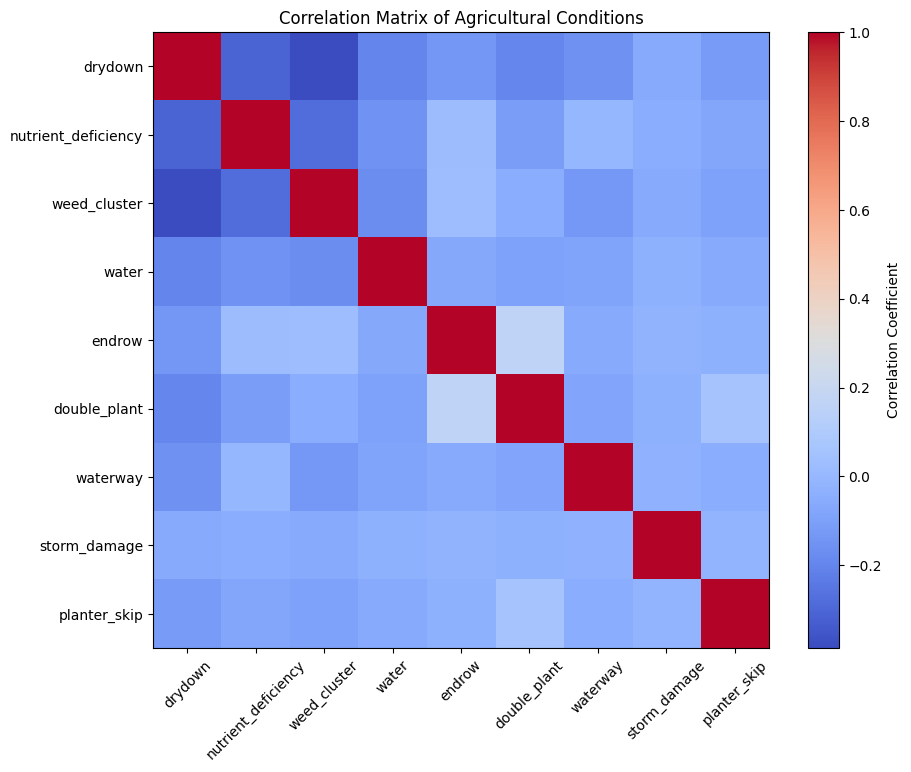

In [21]:
correlations = df[label_columns].corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation Coefficient")
plt.xticks(range(len(label_columns)), label_columns, rotation=45)
plt.yticks(range(len(label_columns)), label_columns)
plt.title("Correlation Matrix of Agricultural Conditions")
plt.show()

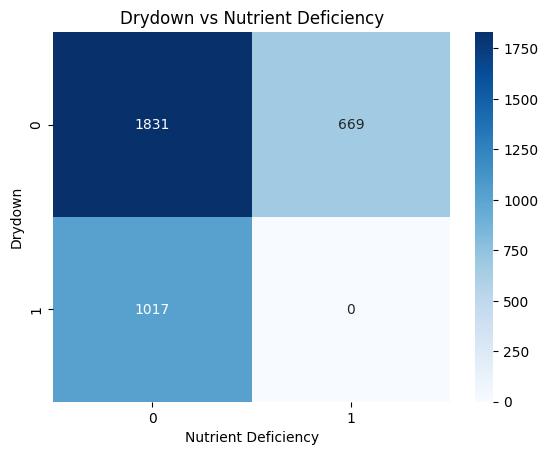

In [22]:
sns.heatmap(pd.crosstab(df["drydown"], df["nutrient_deficiency"]), annot=True, fmt="d", cmap="Blues")
plt.title("Drydown vs Nutrient Deficiency")
plt.ylabel("Drydown")
plt.xlabel("Nutrient Deficiency")
plt.show()

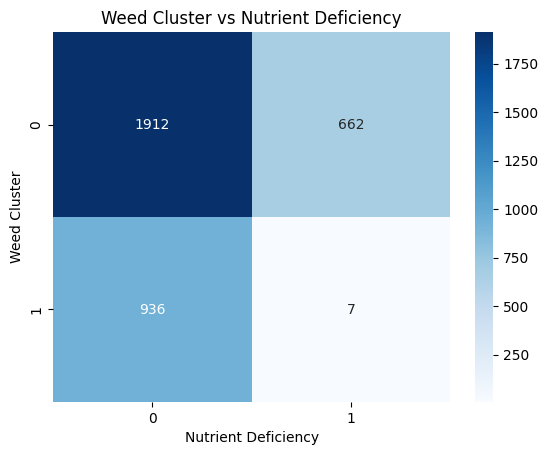

In [23]:
sns.heatmap(pd.crosstab(df["weed_cluster"], df["nutrient_deficiency"]), annot=True, fmt="d", cmap="Blues")
plt.title("Weed Cluster vs Nutrient Deficiency")
plt.ylabel("Weed Cluster")
plt.xlabel("Nutrient Deficiency")
plt.show()

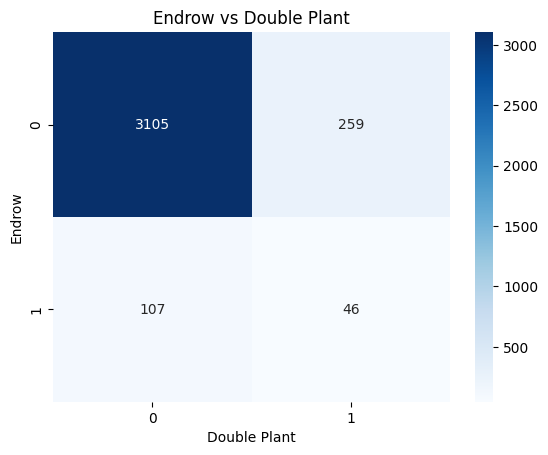

In [24]:
sns.heatmap(pd.crosstab(df["endrow"], df["double_plant"]), annot=True, fmt="d", cmap="Blues")
plt.title("Endrow vs Double Plant")
plt.ylabel("Endrow")
plt.xlabel("Double Plant")
plt.show()

Most conditions show weak correlations, suggesting they occur independently.

Notable moderate correlations exist, such as between nutrient_deficiency and drydown, endrow and double_plant.

# 5. Balancing dataset classes

**Input Data Structure for augmentation**

Image: 4-channel images (RGB + NIR). RGBA (.png)

Mask: Multi-class masks where each pixel represents a class label.

## Pre-processing (RGB+NIR -> RGBN)

In [25]:
images_path = os.path.join(dataset_train_path, "images")
rgb_images_path = os.path.join(images_path, "rgb")
nir_images_path = os.path.join(images_path, "nir")
rgb_images_path

'/mnt/d/AgriNet-Research/agrinet/datasets/Agriculture-Vision-2021/_mini_dataset/train/images/rgb'

### Utils:

In [26]:
def _show_rgbn_image_as_rgb_and_nir(rgbn:np.ndarray) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # RGB Visualization
    axs[0].imshow(rgbn[..., :3])
    axs[0].set_title("RGB")
    axs[0].axis("off")
    
    # NIR Visualization
    axs[1].imshow(rgbn[..., 3], cmap="gray")
    axs[1].set_title("NIR")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


def _show_rgbn_image_by_channels(rgbn: np.ndarray) -> None:
    channels = "RGB"
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    for i, channel in enumerate(channels):
        axs[i].imshow(rgbn[..., i], cmap="gray")
        axs[i].set_title(channel)
        axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()


def save_rgbn_image(rgbn_image:np.ndarray, output_path:str) -> str:
    """Save as a .png file (4 channels)"""
    filename, _ = os.path.splitext(output_path)
    output_path = f"{output_path}.png"
    cv2.imwrite(output_path, cv2.cvtColor(rgbn_image, cv2.COLOR_RGBA2BGRA))
    return output_path


def load_rgbn_image(path:str) -> np.ndarray:
    rgbn_image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return rgbn_image


def get_rgbn_image(
    nir_image_path:str,
    rgb_image_path:str,
) -> np.ndarray | None:
    if not all([os.path.exists(i) for i in [nir_image_path, rgb_image_path]]):
        return
        
    nir_image = cv2.imread(nir_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)
    
    # Resize NIR image to match the RGB image, if necessary
    nir_image = cv2.resize(nir_image, (rgb_image.shape[1], rgb_image.shape[0]))
    
    # Merge the RGB image with NIR (creating a 4-channel image)
    rgbn = np.dstack((rgb_image,nir_image))
    return rgbn

14.2 ms ± 882 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(512, 512, 4)


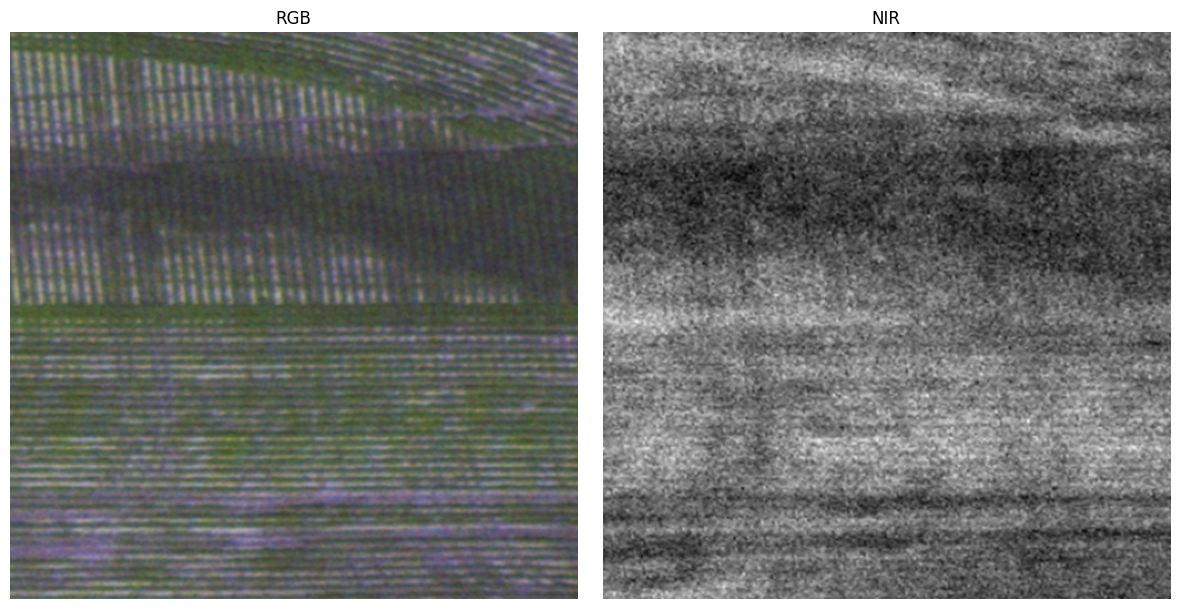

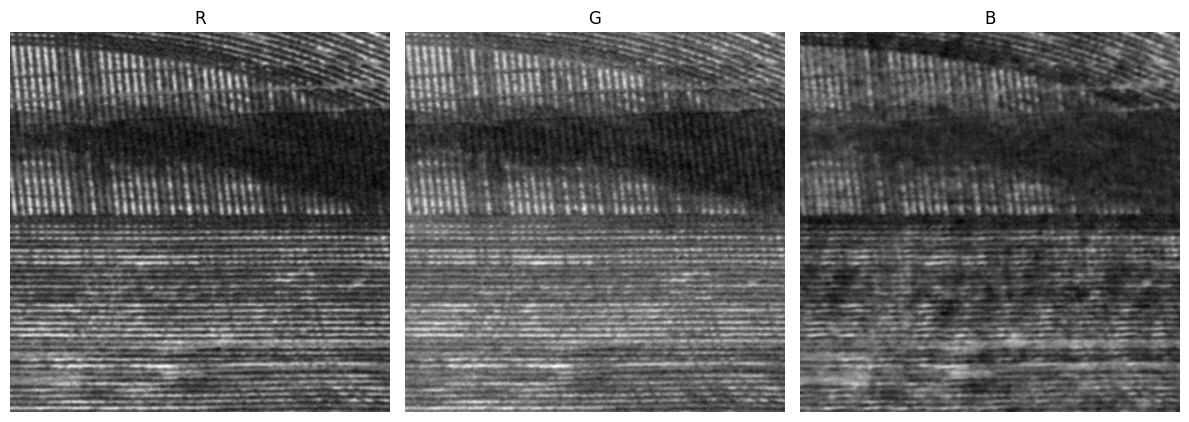

In [27]:
def _test():
    image_name = "11TAQJ6ET_1995-8426-2507-8938.jpg"
    
    nir_image_path = os.path.join(nir_images_path, image_name)
    rgb_image_path = os.path.join(rgb_images_path, image_name)

    %timeit -n 10 get_rgbn_image(nir_image_path=nir_image_path, rgb_image_path=rgb_image_path)
    
    rgbn = get_rgbn_image(
        nir_image_path=nir_image_path,
        rgb_image_path=rgb_image_path,
    )
    if rgbn is None: 
        raise AssertionError(f"Failed load nir + rgb for image {image_name}")
    
    # Save and load image
    output_path = os.path.join(OUTPUT_FOLDER_PATH, image_name)
    path = save_rgbn_image(rgbn, output_path = output_path)
    rgbn = load_rgbn_image(path)
    print(rgbn.shape)
    
    _show_rgbn_image_as_rgb_and_nir(rgbn = rgbn)
    _show_rgbn_image_by_channels(rgbn = rgbn)


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

### Pre-Processing

In [28]:
# TODO add pre-processing

## Pre-processing (Labels -> Multi-label masks)

In [29]:
# TODO add utils and pre-processing

## Augmentation

In [30]:
from albumentations import (
    HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomBrightnessContrast, 
    HueSaturationValue, GaussianBlur, GaussNoise, Compose, RandomCrop, PadIfNeeded
)
from albumentations.core.composition import OneOf

In [31]:
augmentation_pipeline = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    RandomCrop(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=0.5),
    PadIfNeeded(min_width=IMAGE_WIDTH, min_height=IMAGE_HEIGHT, p=1.0),
    OneOf([
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    ], p=0.7),
    OneOf([
        GaussianBlur(blur_limit=(3, 7), p=0.3),
        GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ], p=0.5)
])

In [32]:
# TODO write func for augmentation and save

# TODO 6. EDA (data + augmentation)